In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils
import graphviz
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import ast

In [2]:

FILE_NAME = "census_income"

data = arff.loadarff('../datasets2/census_income.arff')
df = pd.DataFrame(data[0])
str_df = df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df[col] = str_df[col]
for i in range(0,len(df)):
    if str(df.at[i, "sex"]) == "Male":
        df.at[i, "sex"] = 0
    elif str(df.at[i, "sex"]) == "Female":
        df.at[i, "sex"] = 1

    if str(df.at[i, "income_class"]) == "<=50K":
        df.at[i, "income_class"] = 0
    elif str(df.at[i, "income_class"]) == ">50K":
        df.at[i, "income_class"] = 1

for col in df.columns:
    df = df[ df[col] != "?" ]

col = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
df = df.drop(['education-num', 'age', 'capital-gain', 'capital-loss', 'hours-per-week'], axis=1)
#df = df.drop(['native-country'], axis=1)
df = pd.get_dummies(df, columns=col, drop_first=True)
df.reset_index(inplace = True)
del df['index']
X = df.loc[:, ~df.columns.isin(['income_class', 'sex'])]
y = pd.to_numeric(df['income_class'])
sensitive = df['sex']
print(utils.discrimination(y, sensitive))
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)


/tmp/ipykernel_5601/2977305109.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  str_df = df.select_dtypes([np.object])


0.19637403845538565


In [3]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(97, X, y, sensitive)

clf = DL85Classifier(max_depth=7, error_function=lambda tids: utils.error(list(tids), 0, y_train, sensitive_train), min_sup=2, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

print(f'sum discrimination_pred  = {round(sum_discrimination_additive_train_pred, 8)}')
print(f'sum discrimination_pred abs = {round(sum_discrimination_additive_train_pred_abs, 8)}')

dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)


accuracy_pred = 0.77207835
accuracy_test = 0.76626826
discrimination_train = 0.19349383
discrimination_train_pred = 0.07604061
sum discrimination_pred  = 0.07604061
sum discrimination_pred abs = 0.07604061


'\ndot = utils.export_graphviz(clf)\ngraph = graphviz.Source(dot, format="png")\ngraph.render("plots/"+FILE_NAME+"tree")\ngraphviz.Source(dot)\n'

In [4]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(97, X, y, sensitive)


clf = DecisionTreeClassifier(max_depth=7, random_state=0)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
accuracy_train = round(accuracy_score(y_train, y_pred_train),6)
print("Accuracy DL8.5 on training set =", accuracy_train)
discrimation_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 6)
print("Discrimination of classifier on train(pred)", discrimation_train_pred)

Accuracy DL8.5 on training set = 0.832586
Discrimination of classifier on train(pred) 0.158455


In [5]:
import relabeling_pydl

leafs_relab = relabeling_pydl.relab_leaf_limit(clf.tree_, y_train, y_pred_train, sensitive_train, 2)
sum_acc = 0
sum_disc = 0
for leaf in leafs_relab:
    print(leaf)
    relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)
    sum_acc += leaf.acc
    sum_disc += leaf.disc

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

print(f'sum discrimination_pred  = {round(sum_discrimination_additive_train_pred, 8)}')
print(f'sum discrimination_pred abs = {round(sum_discrimination_additive_train_pred_abs, 8)}')

dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)

TypeError: argument of type 'sklearn.tree._tree.Tree' is not iterable

In [ ]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
utils.sum_elem_tree(clf.tree_, "misclassified")

KeyboardInterrupt: 

Error: Canceled future for execute_request message before replies were done

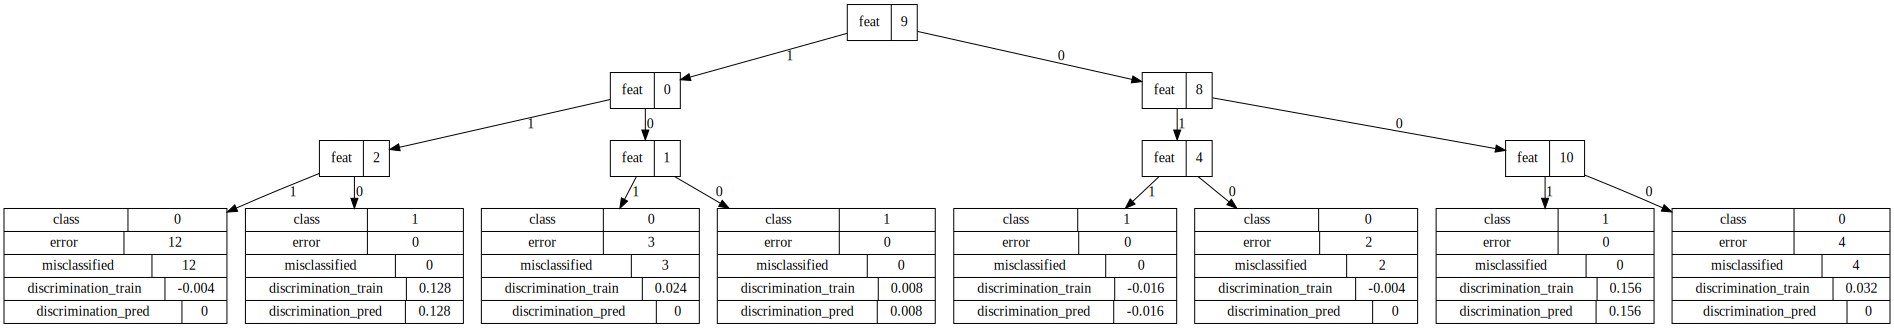

In [ ]:
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)